In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Preprocessing and evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Gaussian Process for prediction
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [13]:
df = pd.read_csv('./data/Realisasi Pendapatan Negara, 2007-2009.csv')
df2 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2010-2012.csv')
df3 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2013-2015.csv')
df4 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2016-2018.csv')
df5 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2019-2021.csv')
df6 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2022-2024.csv')

In [14]:
df.head()

,Sumber Penerimaan - Keuangan,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Realisasi Pendapatan Negara (Milyar Rupiah),NaN,NaN
1,NaN,2007,2008.0,2009.0
2,I. Penerimaan,706108,979305.0,847096.0
3,Penerimaan Perpajakan,490988,658701.0,619922.0
4,Pajak Dalam Negeri,470052,622359.0,601252.0


In [15]:
df2.head()

,Sumber Penerimaan - Keuangan,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Realisasi Pendapatan Negara (Milyar Rupiah),NaN,NaN
1,NaN,2010,2011.0,2012.0
2,I. Penerimaan,992249,1205346.0,1332322.9
3,Penerimaan Perpajakan,723307,873874.0,980518.1
4,Pajak Dalam Negeri,694392,819752.0,930861.8


In [ ]:
penerimaan_pajak = df[df.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df = pd.DataFrame({
    'Tahun': ['2007', '2008', '2009'],
    'Penerimaan Pajak': penerimaan_pajak.values.flatten()
})
cleaned_df.head()

,Tahun,Penerimaan Pajak
0,2007,490988
1,2008,658701.0
2,2009,619922.0


In [17]:
penerimaan_pajak2 = df2[df2.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df2 = pd.DataFrame({
    'Tahun': ['2010', '2011', '2012'],
    'Penerimaan Pajak': penerimaan_pajak2.values.flatten()
})

penerimaan_pajak3 = df3[df3.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df3 = pd.DataFrame({
    'Tahun': ['2013', '2014', '2015'],
    'Penerimaan Pajak': penerimaan_pajak3.values.flatten()
})

penerimaan_pajak4 = df4[df4.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df4 = pd.DataFrame({
    'Tahun': ['2016', '2017', '2018'],
    'Penerimaan Pajak': penerimaan_pajak4.values.flatten()
})

penerimaan_pajak5 = df5[df5.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df5 = pd.DataFrame({
    'Tahun': ['2019', '2020', '2021'],
    'Penerimaan Pajak': penerimaan_pajak5.values.flatten()
})

penerimaan_pajak6 = df6[df6.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df6 = pd.DataFrame({
    'Tahun': ['2022', '2023', '2024'],
    'Penerimaan Pajak': penerimaan_pajak6.values.flatten()
})

In [18]:
df_grouped = pd.concat([cleaned_df, cleaned_df2, cleaned_df3, cleaned_df4, cleaned_df5, cleaned_df6], axis=0).reset_index(drop=True)
print(df_grouped)

   Tahun Penerimaan Pajak
0   2007           490988
1   2008         658701.0
2   2009         619922.0
3   2010           723307
4   2011         873874.0
5   2012         980518.1
6   2013        1077306.7
7   2014        1146865.8
8   2015       1240418.86
9   2016        1284970.1
10  2017        1343529.8
11  2018        1518789.8
12  2019        1546141.9
13  2020       1285136.32
14  2021        1547841.1
15  2022        2034552.5
16  2023        2118348.0
17  2024        2309859.8


In [36]:
# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_grouped[['Penerimaan Pajak']])
scaled_data

array([[0.        ],
       [0.09220716],
       [0.0708868 ],
       [0.12772698],
       [0.21050741],
       [0.26913942],
       [0.32235296],
       [0.36059595],
       [0.41203061],
       [0.4365245 ],
       [0.46872012],
       [0.56507655],
       [0.5801145 ],
       [0.43661588],
       [0.5810487 ],
       [0.84863843],
       [0.89470847],
       [1.        ]])

In [46]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Define the TensorFlow model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for LSTM
X_train = np.reshape(train, (train.shape[0], train.shape[1], 1))
y_train = train[:, 0]  # Assuming the target variable is the first column

# Train the TensorFlow model
model.fit(X_train, y_train, batch_size=1, epochs=50)  # Increase the number of epochs

# Make predictions with the TensorFlow model
X_test = np.reshape(test, (test.shape[0], test.shape[1], 1))
y_pred_tf = model.predict(X_test)

# Use the predictions from the TensorFlow model as input features for the Gaussian Process model
X_gp_train = np.arange(len(y_pred_tf)).reshape(-1, 1)
y_gp_train = y_pred_tf.flatten()

# Define the kernel for the Gaussian Process
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# Create Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process model
gp.fit(X_gp_train, y_gp_train)

# Make predictions with the Gaussian Process model
X_gp_test = np.arange(len(y_pred_tf), len(y_pred_tf) + len(test)).reshape(-1, 1)
y_pred_gp, sigma = gp.predict(X_gp_test, return_std=True)

# Inverse transform the predictions
y_pred_gp = scaler.inverse_transform(y_pred_gp.reshape(-1, 1))

# Evaluate the model
y_test = scaler.inverse_transform(test[:, 0].reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_gp)
mae = mean_absolute_error(y_test, y_pred_gp)
print(f'MSE: {mse}, MAE: {mae}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1437
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015     
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1493e-04 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7381e-04 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7752e-05 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1486e-

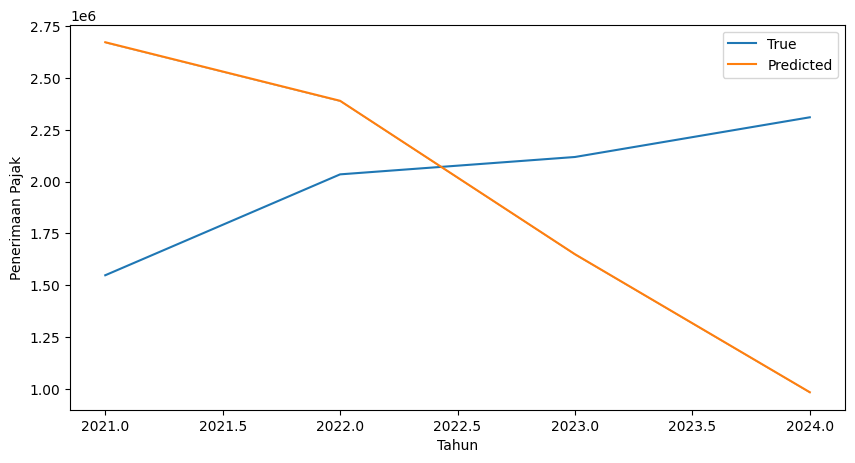

In [47]:
#Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df_grouped['Tahun'][train_size:], y_test, label='True')
plt.plot(df_grouped['Tahun'][train_size:], y_pred_gp, label='Predicted')
plt.fill_between(df_grouped['Tahun'][train_size:], y_pred_gp[:, 0] - 1.96 * sigma, y_pred_gp[:, 0] + 1.96 * sigma, alpha=0.2, color='k')
plt.legend()
plt.xlabel('Tahun')
plt.ylabel('Penerimaan Pajak')
plt.show()